# Machine Learning Programming Exercise 2: Logistic Regression

In [1]:
#import package(s)
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import scipy.optimize as sp
import warnings
warnings.filterwarnings('ignore')

## 1 Logistic Regression
In this part of the exercise, we will build a logistic regression model to predict whether a student gets admitted into a university.

Suppose that an the administrator of a university department wants to determine each applicant’s chance of admission based on their results on two exams. We have historical data from previous applicants that can be used as a training set for logistic regression. For each training example, we have the applicant’s scores on two exams and the admissions decision. 

Our task is to build a classiﬁcation model that estimates an applicant’s probability of admission based the scores from those two exams. 

This problem is a binary classification problem where $y$ can only take on the values zero or one. There are two classes where $y=0$ represents the negative class and $y=1$ represents the positive classes.

<div class="alert alert-block alert-info">
<b>Note:</b> It is not recommended to use linear regression for classification problems. 
   For linear regression, $y$ is quantitative while $y$ is qualitative for classification problems. So, it can be difficult to map qualitative values to quantitative values if there are more than two classes.
   Linear regression may also predict values outside the $[0,1]$ interval, which makes it difficult to use for binary classification.
   In addition, linear regression is sensitive outliers where it can result in a hypothesis function that doesn't predict the values well.
</div>

### 1.1 Visualizing the data
Before implementing a learning algorithm, we visualize the data. There are two classes: admitted and non-admitted appliants. From the plot, there seems to be a clear separation between them. 

Plotting data with + indicating (y=1) examples and o indicating (y=0) examples.



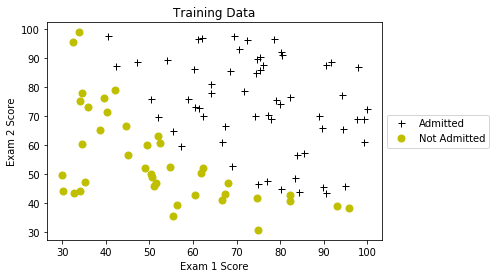

In [2]:
#define function for exercise(s)
def plotData(x,y,lab):
#PLOTDATA Plots the data points X and y into a new figure 
#   PLOTDATA(x,y) plots the data points with + for the positive examples
#   and o for the negative examples. X is assumed to be a Mx2 matrix.

    pos = y==1
    neg = y==0
    plt.figure()
    plt.plot(x[pos,0], x[pos,1], 'k+', markersize=7, label=lab[0])
    plt.plot(x[neg,0], x[neg,1], 'yo', markersize=7, label=lab[1])
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

# ==================== Part 1: Plotting ====================
#We start the exercise by first plotting the data to understand the 
#the problem we are working with

#Load Data
#The first two columns contains the exam scores and the third column
#contains the label.
data = loadtxt('ex2data1.txt',delimiter = ",")

X = data[:,0:2] 
#data from the first column (test 1 scores) and second column (test 2 scores)
y = data[:,2] 
ycol = y.reshape(y.shape[0],1)
#reshape y to be column vector
#data from the third column (admitted/not admitted)

print('Plotting data with + indicating (y=1) examples and o indicating (y=0) examples.\n')
#Labels and Legend 
plotlabels = ['Admitted', 'Not Admitted']
plotData(X,y,plotlabels)
plt.ylabel('Exam 2 Score')
plt.xlabel('Exam 1 Score')
plt.title('Training Data')
plt.show()

### 1.2 Hypothesis Function

Recall that the logistic regression hypothesis is deﬁned as: 
$\begin{align*} h_{\theta} (x) = g(\theta^T x) \end{align*}$,
where function g is the sigmoid function. The sigmoid function is deﬁned as:
$\begin{align*} g(z) = \frac{1}{1+e^{-z}} \end{align*}$. It is also called the logistic function. 

<b>Interpretation of hypothesis function</b>

$h_{\theta}(x)$ is the estimated probability that the output is $y=1$ given we have observed $x$ and $\theta$. For example, if $h_{\theta}(x) = 0.7$ and $y=1$ represents the malignant tumor class, the interpretation is that the patient's tumor is $70\%$ malignant.

<b>Decision boundary</b>

Below is a sample plot of the sigmoid function. When $z$ takes on nonnegative values ($z \geq 0$), $g(z) \geq 0.5$ and when $z$ takes on negative values ($z < 0$), $g(z) < 0.5$. 

This threshold is used for the prediction of the positive and negative classes in logistic regression:
We predict $y=1$ (positive class) if $h_{\theta} (x) \geq 0.5$ and predict $y=0$ (negative class) if $h_{\theta} (x) < 0.5$.

The decision boundary separates the classes using the hypothesis function and its parameters, not the training data. 

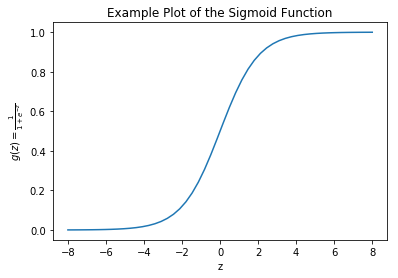

In [3]:
#define function for exercise(s)
def sigmoid(z):
#SIGMOID Compute sigmoid function
#   g = SIGMOID(z) computes the sigmoid of z.
    g = 1/(1 + np.exp(-z))
    return g

z = np.linspace(-8,8,50)
g = sigmoid(z)
plt.plot(z,g)
plt.ylabel(r'$g(z) = \frac{1}{1+e^{-z}}$')
plt.xlabel('z')
plt.title('Example Plot of the Sigmoid Function')
plt.show()

### 1.3 Cost Function and Gradient
The cost function for logistic regression is 
$\begin{align*} J(\theta) = \frac{1}{m} \sum_{i=1}^m \left [ -y^{(i)} \log(h_{\theta} (x^{(i)})) - (1-y^{(i)}) \log(1-h_{\theta} (x^{(i)})) \right ]\end{align*}$, and the gradient for logistic regression is 
$\begin{align*} \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m ( h_{\theta} (x^{(i)}) -y^{(i)} ) x^{(i)}_j \end{align*}$. While this gradient looks identical to the linear regression gradient, the formula is actually diﬀerent because linear and logistic regression have diﬀerent deﬁnitions of the hypothesis function $h_{\theta}(x)$.

**Cost Function Intuition**:

The cost function is heavily penalized when it predicts the wrong value. This will also ensure that the values of the cost function will be kept small. 
* If $y=1$ was observed, then the cost is high when $h_{\theta} = 0$. That is, $Cost(h_{\theta}(x),y) \to \infty$ if $y=1$ and $h_{\theta} \to 0$.
* If $y=0$ was observed, then the cost is high when $h_{\theta} = 1$. That is, $Cost(h_{\theta}(x),y) \to \infty$ if $y=0$ and $h_{\theta} \to 1$.

Image source: Image from Andrew Ng's Machine Learning course on Coursera used for illustration.
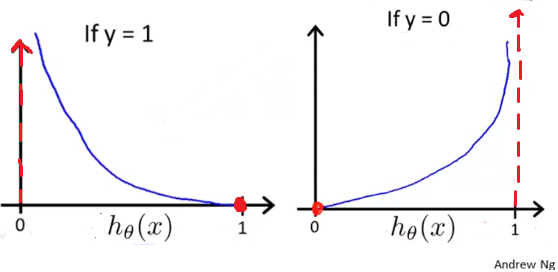

We can think of the cost function as the following:
$ 
    Cost(h_{\theta}(x),y) = \begin{cases}
        - \log(h_{\theta} (x)), & \text{for } y=1 \\
        - \log(1-h_{\theta} (x)), & \text{for } y=0
        \end{cases}
  $

For my code below, I decided to have separate functions for the cost and gradient exercises instead of having one function to compute them both. This will be convenient when optimizing the cost function. 

In [4]:
#define function for exercise(s)
def sigmoid(z):
#SIGMOID Compute sigmoid function
#   g = SIGMOID(z) computes the sigmoid of z.
    g = 1/(1 + np.exp(-z))
    return g

def hypfunc(theta,X):
# hypothesis function: returns sigmoid(X * theta)
    X = np.matrix(X)
    theta = np.matrix(theta)
    return sigmoid(X * theta.T)

def costFunction(theta, X, y): 
#COSTFUNCTION Compute cost for logistic regression
#   J = COSTFUNCTION(theta, X, y) computes the cost of using theta as the
#   parameter for logistic regression 
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    h = hypfunc(theta,X)
    first = np.multiply(-y, np.log(h))
    second = np.multiply((1 - y), np.log(1 - h))
    return (first - second).mean()

def gradient(theta, X, y):
#GRADIENT Compute gradient for logistic regression
#   G = GRADIENT(theta, X, y) computes the gradient of the cost
#   w.r.t. to the parameters.    
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    parameters = int(theta.shape[1])
    grad = np.zeros(parameters)
    for i in range(parameters):
        term = np.multiply(hypfunc(theta,X) - y, X[:,i])
        grad[i] = term.mean()
    return grad

# ============ Part 2: Compute Cost and Gradient ============
#  In this part of the exercise, you will implement the cost and gradient
#  for logistic regression. You neeed to complete the code in 
#  costFunction.m

#Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape
X = np.column_stack((np.ones((m,1)), X))

#Initialize fitting parameters
initial_theta = np.zeros((n+1))

#Compute and display initial cost and gradient
cost = costFunction(initial_theta, X, ycol)
grad = gradient(initial_theta, X, ycol)

print('Cost at initial theta (zeros): ', cost)
print('Expected cost (approx): 0.693\n')
print('Gradient at initial theta (zeros): ', grad)
print('Expected gradients (approx):\n -0.1000\n -12.0092\n -11.2628\n')

#Compute and display cost and gradient with non-zero theta
test_theta = np.array([[-24, 0.2, 0.2]])
cost = costFunction(test_theta, X, ycol)
grad = gradient(test_theta, X, ycol)

print('Cost at test theta: ', cost)
print('Expected cost (approx): 0.218\n')
print('Gradient at test theta: ', grad)
print('Expected gradients (approx):\n 0.043\n 2.566\n 2.647\n')

Cost at initial theta (zeros):  0.6931471805599453
Expected cost (approx): 0.693

Gradient at initial theta (zeros):  [ -0.1        -12.00921659 -11.26284221]
Expected gradients (approx):
 -0.1000
 -12.0092
 -11.2628

Cost at test theta:  0.21833019382659777
Expected cost (approx): 0.218

Gradient at test theta:  [0.04290299 2.56623412 2.64679737]
Expected gradients (approx):
 0.043
 2.566
 2.647



### 1.4 Learning parameters using scipy.optimize.fmin_bfgs
In the linear regression exercise, we found the optimal parameters by implementing gradient descent. For logistic regression, we will use one of Scipy's optimization solver, fmin_bfgs, to find the $\theta$ parameters that optimizes the cost function $J(\theta)$. This solver uses the BFGS algorithm and is similar to Octave/MATLAB's fminunc. Another option is to use fmin_tnc and it would give the same results. 

To use the optimizing algorithm: 
* define an initial value for $\theta$. 
* define functions that compute the logisitc regression cost function and its gradient with respect to $\theta$ for the dataset $(X, y)$
* the arguments $X, y,$ and $\theta$ must be arrays, but they must be converted to matrices in the cost and gradient functions because the algorithm uses numpy matrices operations. For the same reason, $\theta$ is a row vector. 

Cost at theta found by fmin_bfgs:  0.20349770158944377
Expected cost (approx): 0.203

theta: 
 [-25.16133284   0.2062317    0.2014716 ]

Expected theta (approx): 
-25.161
 0.206
 0.201



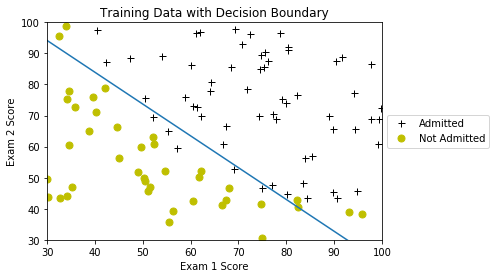

In [5]:
#define function for exercise(s)
def mapFeature(X1,X2):
# MAPFEATURE Feature mapping function to polynomial features
#   MAPFEATURE(X1, X2) maps the two input features
#   to quadratic features used in the regularization exercise.
#   Returns a new feature array with more features, comprising of 
#   X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    
   #Inputs X1, X2 must be the same size
    degree = 6
    #if X1 has zero dimensions (ie a scalar) then out is a 1 by 1 array
    if np.ndim(X1) == 0:
        out = np.ones((1,1))
    else:
        #else out is a len(X1) by 1 array
        out = np.ones((len(X1),1))
        
    for i in range(1,degree+1):
        for j in range(i+1):
            feature = np.power(X1,i-j)*np.power(X2,j)
            out = np.column_stack((out, feature))
    return out

def plotDecisionBoundary(theta, X, y, lab):
#PLOTDECISIONBOUNDARY Plots the data points X and y into a new figure with
#the decision boundary defined by theta
#   PLOTDECISIONBOUNDARY(theta, X,y) plots the data points with + for the 
#   positive examples and o for the negative examples. X is assumed to be 
#   a either 
#   1) Mx3 matrix, where the first column is an all-ones column for the 
#      intercept.
#   2) MxN, N>3 matrix, where the first column is all-ones
    
    plotData(X[:,1:3], y, lab[0:2])
    
    if X.shape[1] <= 3:
        plot_x = np.array([min(X[:,1])-2, max(X[:,1])+2])
        plot_y = -(theta[1]*plot_x + theta[0])/theta[2]
        plt.plot(plot_x, plot_y, label=lab[2])
        plt.axis([30, 100, 30, 100])
    else:
        # Here is the grid range
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((len(u), len(v)))
        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = np.dot(mapFeature(u[i], v[j]),theta)
        # important to transpose z before calling contour
        z = z.T 

        # Plot z = 0
        # Notice you need to specify the range [0, 0]
        plt.contour(u, v, z, levels=[0], linewidths=2)
        
# ============= Part 3: Optimizing using fmin_bfgs  =============
#  In this exercise, you will use scipy.optimize.fmin_bfgs to find the
#  optimal parameters theta.

#Run fmin_bfgs to obtain the optimal theta
#use that value to get the optimal cost
result = sp.fmin_bfgs(f = costFunction, x0 = initial_theta, args = (X,ycol), fprime = gradient, maxiter = 400, disp=False)
theta_opt = result
cost_opt = costFunction(theta_opt, X, ycol) 

#Print theta to screen
print('Cost at theta found by fmin_bfgs: ', cost_opt)
print('Expected cost (approx): 0.203\n')
print('theta: \n', theta_opt)
print('\nExpected theta (approx): ')
print('-25.161\n 0.206\n 0.201\n')

#Specified in plot order
dblabels = ['Admitted', 'Not Admitted', 'Decision Boundary']
#Plot Boundary
plotDecisionBoundary(theta_opt, X, y, dblabels)
#adjust axes for better viewing
plt.axis([30, 100, 30, 100])
#Put some labels 
plt.ylabel('Exam 2 Score')
plt.xlabel('Exam 1 Score')
plt.title('Training Data with Decision Boundary')
plt.show()

In the plot above, the decision boundary is linear. There is a conditional statement in the function plotDecisionBoundary that plots either a linear or non-linear decision boundary based on the number of columns for the matrix $X$.

### 1.5 Evaluating logistic regression
After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, the expected admission probability should be 0.776.

Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. Find the training accuracy of the classiﬁer by computing the percentage of examples it got correct.

In [6]:
#define function for exercise(s)
def predict(theta, X):
#PREDICT Predict whether the label is 0 or 1 using learned logistic 
#regression parameters theta
#   p = PREDICT(theta, X) computes the predictions for X using a 
#   threshold at 0.5 (i.e., if sigmoid(theta'*x) >= 0.5, predict 1)
    # Number of training examples
    m = X.shape[0] 
    p = np.zeros((m,1))
    # You need to return the following variables correctly
    h = hypfunc(theta,X)
    p[h>=0.5] = 1
    return np.matrix(p)

# ============== Part 4: Predict and Accuracies ==============
#  After learning the parameters, you'll like to use it to predict the outcomes
#  on unseen data. In this part, you will use the logistic regression model
#  to predict the probability that a student with score 45 on exam 1 and 
#  score 85 on exam 2 will be admitted.
#  Furthermore, you will compute the training and test set accuracies of 
#  our model.

#Predict probability for a student with score 45 on exam 1 
#and score 85 on exam 2 

prob = hypfunc(np.array([[1, 45, 85]]), theta_opt)
print('For a student with scores 45 and 85, we predict an admission')
print('probability of: ', prob)
print('Expected value: 0.775 +/- 0.002\n\n')

#compute accuracy on our training set
p = predict(theta_opt, X)
print('Train Accuracy: ', (np.mean(np.equal(p.T, y.T)))*100)
print('Expected accuracy (approx): 89.0')

For a student with scores 45 and 85, we predict an admission
probability of:  [[0.77629072]]
Expected value: 0.775 +/- 0.002


Train Accuracy:  89.0
Expected accuracy (approx): 89.0
